In [1]:
!pip install transformers matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [2]:
from transformers import AutoTokenizer, AutoModel
import torch

# Use BERT, a classic Transformer encoder model
model_name = "bert-base-uncased" # there is also "cased", and generally, many other models
# For multilingual we could also use
# model_name = PlanTL-GOB-ES/roberta-base-bne" https://huggingface.co/PlanTL-GOB-ES/roberta-base-bne
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True) # Pretrained

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [22]:
# Try a different sentence at home

#sentence = "The bank robber drew a gun on the river bank."
sentence = "I can’t bear to see my old teddy bear collecting dust"
# if you change the language, you get a tokenization issue, it doesn't know the langugage and doesn't know what to do it
inputs = tokenizer(sentence, return_tensors="pt") # "pt" for PyTorch tensors

# Get the model's output
with torch.no_grad():
    outputs = model(**inputs)

# The attention weights are in outputs.attentions
# First layer.
attention_layer_0 = outputs.attentions[0]
print("Attention tensor shape:", attention_layer_0.shape)
# Shape: [batch_size, num_heads, sequence_length, sequence_length]

Attention tensor shape: torch.Size([1, 12, 15, 15])


The sentence tokens vector: 
tensor([[  101,  1045,  2064,  1521,  1056,  4562,  2000,  2156,  2026,  2214,
         11389,  4562,  9334,  6497,   102]])
tokens: 
['[CLS]', 'i', 'can', '’', 't', 'bear', 'to', 'see', 'my', 'old', 'teddy', 'bear', 'collecting', 'dust', '[SEP]']


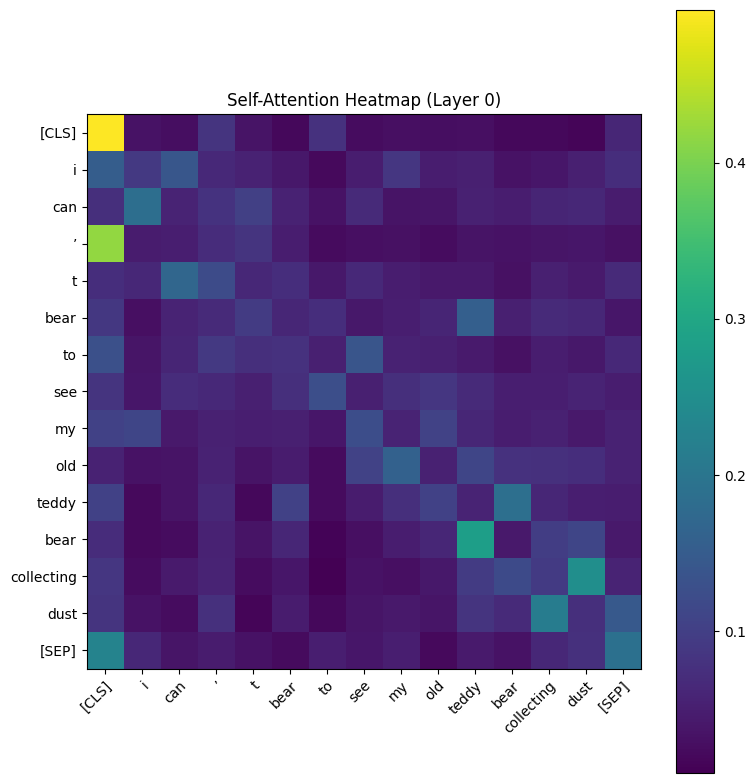

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Average the attention weights across all heads, "flatten" into 2D
attention_heads_avg = attention_layer_0[0].mean(axis=0).numpy()

# Get the tokens for labeling the plot
print("The sentence tokens vector: ")
print(inputs['input_ids'])
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print("tokens: ")
print(tokens)


# Create a new figure and axis for plotting, setting figure size to 8x8 inches
fig, ax = plt.subplots(figsize=(8, 8))

# Display the attention weights matrix as an image (heatmap) using the 'viridis' colormap
im = ax.imshow(attention_heads_avg, cmap="viridis")

# Set tick positions along x and y axes (one tick per token)
ax.set_xticks(np.arange(len(tokens)))
ax.set_yticks(np.arange(len(tokens)))

# Label ticks with the actual token strings
ax.set_xticklabels(tokens)
ax.set_yticklabels(tokens)

# Rotate x-axis tick labels for readability (45 degrees, right-aligned)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add a colorbar to the figure to show the scale of attention values
fig.colorbar(im, ax=ax)

# Add a descriptive title to the heatmap
ax.set_title("Self-Attention Heatmap (Layer 0)")

# Adjust layout so everything fits without overlapping
fig.tight_layout()

# Render and display the plot
plt.show()

# We can notice the difference in correlation in between of the two robber
# robber-robber robber-river

# It was interesting to see that bear/see teddy/bear didn't work as expected. This seems to be due to to BERT being an old model.

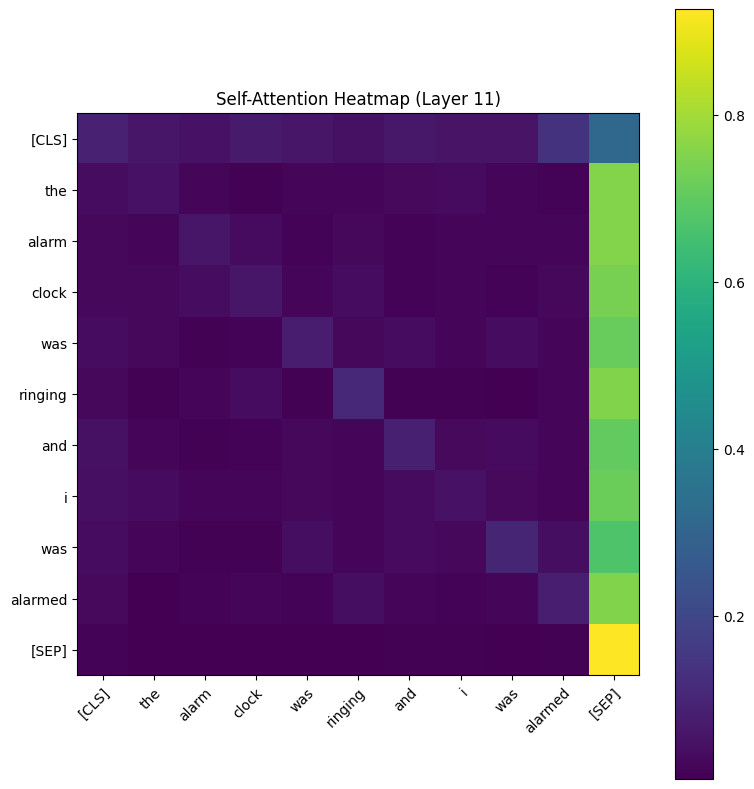

In [19]:
# --- Plot for Layer 11 ---

# Model has 12 attention layer, this is the last one. And we don't really have any kind of information but the last part of the sentence.
# Just the end of the sentence and not much else

# Extract attention from the last layer (index 11)
attention_layer_11 = outputs.attentions[11]
# Average the attention weights across all 12 heads for this layer
attention_heads_avg_11 = attention_layer_11[0].mean(axis=0).numpy()

# Create a new figure and axis for the second plot
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(attention_heads_avg_11, cmap="viridis")

# Set up labels and ticks (same as before, as tokens don't change)
ax.set_xticks(np.arange(len(tokens)))
ax.set_yticks(np.arange(len(tokens)))
ax.set_xticklabels(tokens)
ax.set_yticklabels(tokens)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(im, ax=ax)
# IMPORTANT: Update the title for the new plot
ax.set_title("Self-Attention Heatmap (Layer 11)")
fig.tight_layout()
plt.show()


In [11]:
# ## Step 1: Import Necessary Libraries ##

import torch
# Module for creating plots and graphs. We give it a shorter name, 'plt'.
import matplotlib.pyplot as plt
# Efficient numerical operations, especially for creating our range of sequence lengths.
import numpy as np


# ## Step 2: Setup the Computation Environment ##

# In deep learning, you can run calculations on a CPU or a much faster GPU.
# This line checks if a CUDA-enabled GPU is available in the environment (like in Google Colab).
# If yes, it sets the 'device' to 'cuda'; otherwise, it falls back to the 'cpu'.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") # Let's confirm which device we're using.



Using device: cpu


In [7]:
# ## Step 3: Define Parameters for our Attention Simulation ##

# --- Attention Parameters ---
# Batch Size: How many sequences we process at once. We use 1 to focus purely on the effect of sequence length.
batch_size = 1
# Number of Heads: In Multi-Head Attention, the model splits its attention mechanism into multiple "heads"
# to focus on different parts of the input simultaneously. 8 is a common number.
num_heads = 8
# Model Dimension (d_model): The total size of the vector used to represent each token (word) in the sequence.
d_model = 512
# Head Dimension (d_head): The total model dimension is split evenly among the heads.
# So each head will work with smaller vectors of size 64 (512 / 8).
d_head = d_model // num_heads

In [8]:

# ## Step 4: Create a Function to Isolate and Time the Core Operation ##

# We create a function to keep our main loop clean. It will perform the timing for one sequence length.
def time_attention_operation(seq_len):
    """Creates dummy tensors and accurately times the QKᵀ matrix multiplication on the GPU."""

    # Create dummy Query (q) and Key (k) tensors with random data.
    # We don't need real words, just tensors of the correct SHAPE to measure performance.
    # The shape is (batch_size, num_heads, sequence_length, head_dimension).
    q = torch.randn(batch_size, num_heads, seq_len, d_head).to(device)
    k = torch.randn(batch_size, num_heads, seq_len, d_head).to(device)

    # --- WARM-UP RUN ---
    # The very first time you run an operation on a GPU, it can be slower due to setup costs.
    # We run the operation once here without timing it to "warm up" the GPU.
    _ = torch.matmul(q, k.transpose(-2, -1))
    # GPU operations are asynchronous (the CPU doesn't wait for them to finish).
    # torch.cuda.synchronize() forces the CPU to wait until the GPU has finished all previous tasks.
    # This ensures our warm-up is complete before we start the real timing.
    torch.cuda.synchronize()

    # --- TIMED RUN ---
    # For accurate GPU timing, we use torch.cuda.Event objects. They act like high-precision
    # stopwatches that live directly on the GPU, avoiding CPU-to-GPU communication delays.
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    # Record the "start" time.
    start_event.record()

    # THIS IS THE CORE O(n^2) OPERATION!
    # `torch.matmul` performs matrix multiplication.
    # `k.transpose(-2, -1)` swaps the last two dimensions of the Key tensor.
    # This multiplies a (..., seq_len, d_head) matrix by a (..., d_head, seq_len) matrix,
    # resulting in a (..., seq_len, seq_len) attention score matrix. The cost scales with seq_len squared.
    attention_scores = torch.matmul(q, k.transpose(-2, -1))

    # Record the "end" time.
    end_event.record()

    # Synchronize again to ensure the timed operation is fully complete before we measure the time.
    torch.cuda.synchronize()

    # Calculate and return the elapsed time in milliseconds.
    return start_event.elapsed_time(end_event)


In [12]:

# ## Step 4: Create a Function to Isolate and Time the Core Operation ##

# We create a function to keep our main loop clean. It will perform the timing for one sequence length.
def time_attention_operation(seq_len):
    """Creates dummy tensors and accurately times the QKᵀ matrix multiplication on the GPU."""

    # Create dummy Query (q) and Key (k) tensors with random data.
    # We don't need real words, just tensors of the correct SHAPE to measure performance.
    # The shape is (batch_size, num_heads, sequence_length, head_dimension).
    q = torch.randn(batch_size, num_heads, seq_len, d_head).to(device)
    k = torch.randn(batch_size, num_heads, seq_len, d_head).to(device)

    # --- WARM-UP RUN ---
    # The very first time you run an operation on a GPU, it can be slower due to setup costs.
    # We run the operation once here without timing it to "warm up" the GPU.
    _ = torch.matmul(q, k.transpose(-2, -1))
    # GPU operations are asynchronous (the CPU doesn't wait for them to finish).
    # torch.cuda.synchronize() forces the CPU to wait until the GPU has finished all previous tasks.
    # This ensures our warm-up is complete before we start the real timing.
    torch.cuda.synchronize()

    # --- TIMED RUN ---
    # For accurate GPU timing, we use torch.cuda.Event objects. They act like high-precision
    # stopwatches that live directly on the GPU, avoiding CPU-to-GPU communication delays.
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    # Record the "start" time.
    start_event.record()

    # THIS IS THE CORE O(n^2) OPERATION!
    # `torch.matmul` performs matrix multiplication.
    # `k.transpose(-2, -1)` swaps the last two dimensions of the Key tensor.
    # This multiplies a (..., seq_len, d_head) matrix by a (..., d_head, seq_len) matrix,
    # resulting in a (..., seq_len, seq_len) attention score matrix. The cost scales with seq_len squared.
    attention_scores = torch.matmul(q, k.transpose(-2, -1))

    # Record the "end" time.
    end_event.record()

    # Synchronize again to ensure the timed operation is fully complete before we measure the time.
    torch.cuda.synchronize()

    # Calculate and return the elapsed time in milliseconds.
    return start_event.elapsed_time(end_event)


import torch
import time

# Here I created a slightly different of the function so it would use only CPU, it somehow works as well

def time_attention_operation_cpu(seq_len):
    """Creates dummy tensors and accurately times the QKᵀ matrix multiplication on the CPU."""

    # Create dummy Query (q) and Key (k) tensors with random data on the CPU.
    q = torch.randn(batch_size, num_heads, seq_len, d_head) 
    k = torch.randn(batch_size, num_heads, seq_len, d_head)

    # --- WARM-UP RUN ---
    # Perform a warm-up run to avoid initial setup costs. Not sure if we need that for CPU?
    _ = torch.matmul(q, k.transpose(-2, -1))
    
    # --- TIMED RUN ---
    start_time = time.time()  # Start timing

    # THIS IS THE CORE O(n^2) OPERATION!
    # `torch.matmul` performs matrix multiplication.
    # `k.transpose(-2, -1)` swaps the last two dimensions of the Key tensor.
    # This multiplies a (..., seq_len, d_head) matrix by a (..., d_head, seq_len) matrix,
    # resulting in a (..., seq_len, seq_len) attention score matrix. The cost scales with seq_len squared.
    attention_scores = torch.matmul(q, k.transpose(-2, -1))

    elapsed_time_ms = (time.time() - start_time) * 1000  

    # Return the elapsed time in milliseconds
    return elapsed_time_ms



In [13]:
# ## Step 5: Run the Benchmark Across Different Sequence Lenths ##

# --- Generate the sequence lengths we want to test ---
# np.arange(start, stop, step) creates an array of numbers.
# We'll test lengths from 256 up to 4096, in steps of 256. This gives us 16 data points.
sequence_lengths = np.arange(256, 4097, 256)
# Create an empty list to store the timing results from each run.
timings_ms = []

print("Starting performance measurement with more data points...")
# Loop through each sequence length we defined.
for seq_len in sequence_lengths:
    # Use a try/except block to handle potential errors.
    try:
        # Call our timing function for the current sequence length.
        elapsed_time_ms = time_attention_operation_cpu(seq_len)
        # Add the result to our list of timings.
        timings_ms.append(elapsed_time_ms)
        # Print the result so we can see the progress. The formatting just makes it align nicely.
        print(f"Sequence Length: {seq_len:<5}, Time: {elapsed_time_ms:.4f} ms")
    # If the tensors are too large, we can run out of GPU memory.
    # This `except` block catches that specific error so the program doesn't crash.
    except torch.cuda.OutOfMemoryError:
        print(f"Sequence Length: {seq_len:<5}, FAILED: Out of GPU memory.")
        # If we fail, we stop the loop and trim the lengths list to match the successful timings we have.
        sequence_lengths = sequence_lengths[:len(timings_ms)]
        break

print("Measurement complete.")

Starting performance measurement with more data points...
Sequence Length: 256  , Time: 1.2310 ms
Sequence Length: 512  , Time: 5.2078 ms
Sequence Length: 768  , Time: 9.2072 ms
Sequence Length: 1024 , Time: 16.9268 ms
Sequence Length: 1280 , Time: 19.7318 ms
Sequence Length: 1536 , Time: 21.3485 ms
Sequence Length: 1792 , Time: 30.8628 ms
Sequence Length: 2048 , Time: 38.2140 ms
Sequence Length: 2304 , Time: 48.3153 ms
Sequence Length: 2560 , Time: 72.2620 ms
Sequence Length: 2816 , Time: 73.8988 ms
Sequence Length: 3072 , Time: 94.2748 ms
Sequence Length: 3328 , Time: 106.1749 ms
Sequence Length: 3584 , Time: 124.7327 ms
Sequence Length: 3840 , Time: 123.8370 ms
Sequence Length: 4096 , Time: 151.1497 ms
Measurement complete.


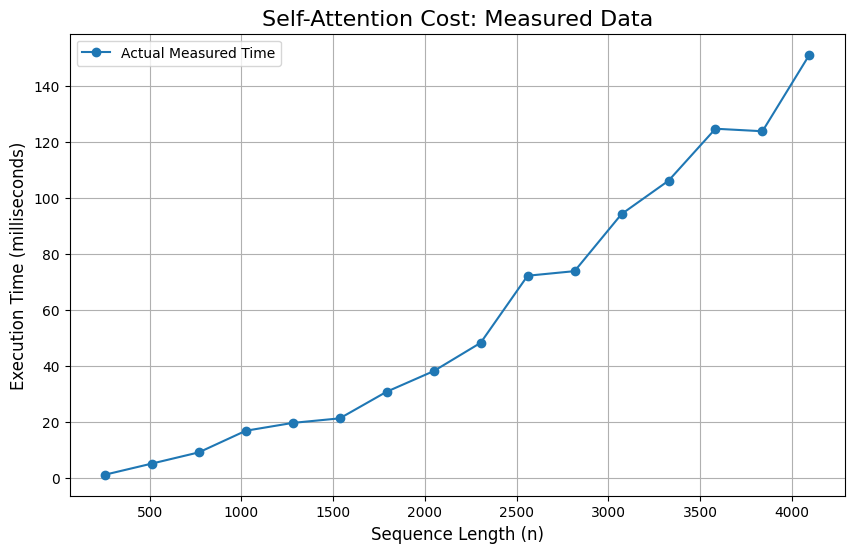

In [14]:
# ## Step 6: Plot the Results ##

# Create a new figure (the plotting window) and set its size for better readability.
plt.figure(figsize=(10, 6))

# The main plotting command.
# It plots `sequence_lengths` on the x-axis and `timings_ms` on the y-axis.
# 'o-' is a style format: 'o' creates a circle marker at each data point,
# and '-' connects the markers with a solid line.
plt.plot(sequence_lengths, timings_ms, 'o-', label='Actual Measured Time')

# Add labels to the graph.
plt.title('Self-Attention Cost: Measured Data', fontsize=16)
plt.xlabel('Sequence Length (n)', fontsize=12)
plt.ylabel('Execution Time (milliseconds)', fontsize=12)

# Display the legend (the label we defined in the plt.plot command).
plt.legend()
# Add a grid to the background to make it easier to read the values.
plt.grid(True)
# Display the final plot.
plt.show()